In [1]:
from quadmodel.quad_model import QuadLensSystem  
from quadmodel.macromodel import MacroLensModel
from quadmodel.deflector_models.sis import SIS
from quadmodel.Solvers.hierachical import HierarchicalOptimization
from quadmodel.Solvers.brute import BruteOptimization
from quadmodel.deflector_models.preset_macromodels import EPLShearMultipole

from pyHalo.single_realization import SingleHalo

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions

from pyHalo.preset_models import CDM
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

### Create some mock data

[0.63089855 0.86377857 1.         0.18266985]


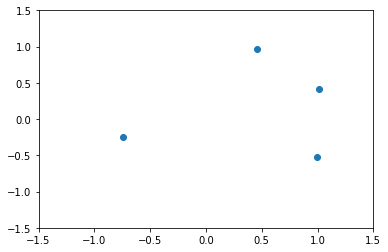

In [2]:
z_lens = 0.5
z_source = 2.0
lens_model_macro = LensModel(['EPL','SHEAR'])
kwargs_macro = [{'theta_E': 1.0, 'center_x': 0.0, 'center_y': 0.0, 'e1': 0.2, 'e2': 0.1, 'gamma':2.0},
                {'gamma1': 0.05, 'gamma2':-0.01}]
solver = LensEquationSolver(lens_model_macro)
ext = LensModelExtensions(lens_model_macro)
source_x, source_y = 0.14 , 0.05
x_image, y_image = solver.image_position_from_source(source_x, source_y, kwargs_macro)
plt.scatter(x_image, y_image)

source_size_parsec = 50.
magnifications = ext.magnification_finite_adaptive(x_image, y_image, source_x, source_y, kwargs_macro, source_size_parsec, z_source)
fluxes = magnifications/max(magnifications)
print(fluxes)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

class Data(object):
    def __init__(self, x, y, fluxes):
        self.x = x
        self.y = y
        self.m = fluxes
        
data = Data(x_image, y_image, fluxes)


### First set up the lens model and create the population of dark matter halos with pyHalo

You can pass several keyword arguments into the CDM function that affect the number and abundance of dark matter halos generated. In particular, the parameter sigma_sub determines the number of subhalos around the lensing galaxy, and the parameter delta_power_law_index changes the slope of the halo mass function.

In [46]:
#realization = CDM(zlens, zsource, sigma_sub=sigma_sub, delta_power_law_index=delta_power_law_index)
halo_mass = 10 ** 5.5
halo_x = x_image[2] + 0.0
halo_y = y_image[2] + 0.02

single_halo_realization = SingleHalo(halo_mass, halo_x, halo_y, 'TNFW', z_lens, z_lens, z_source)
print('realization contains '+str(len(single_halo_realization.halos))+' halos')
# Can optionally turn off halos
print(single_halo_realization.lensing_quantities())
#single_halo_realization = None

main_lens_fit = EPLShearMultipole(z_lens, gamma_macro=2.0, shear_amplitude=0.05, multipole_amplitude=-0.0,
                                 r_ein_approx=1.0, center_x=0.0, center_y=0.0, e1=0.1, e2=0.2)
macromodel = MacroLensModel(main_lens_fit.component_list)
#lens_system = QuadLensSystem.shift_background_auto(data, macromodel, zsource, single_halo_realization)

# Note, when using a single_halo lens model, don't use the shift_background_auto method to create the class
lens_system = QuadLensSystem(macromodel, z_source, single_halo_realization)

realization contains 1 halos
(['TNFW'], [0.5], [{'alpha_Rs': 1.72931e-05, 'Rs': 0.0116613737, 'center_x': 1.0118, 'center_y': 0.4371, 'r_trunc': 0.2009938893867292}], None)


### Fit a lens model

Now we adjust the parameters describing the mass profile of the main deflector ("kwargs_macromodel") so that we get a lens system with the same image positions as in the data with the halos included in the lens model.

In [ ]:
verbose = True # verbose controls how much stuff gets printed to screen
# this will print the output from the fitting process. Set it to False to save space if you want
optimizer = HierarchicalOptimization(lens_system)
kwargs_lens_final, lens_model_full, return_kwargs = optimizer.optimize(data, constrain_params=None,
                                                   param_class_name='free_shear_powerlaw',
                                                                       verbose=verbose)
print(kwargs_lens_final)

optimization 1
aperture size:  100
minimum mass in aperture:  7.0
minimum global mass:  7.0
N foreground halos:  0
N subhalos:  0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
Max iteration reached! Stopping.
PSO done... 
source plane chi^2:  141926.7045050466
total chi^2:  141926.7045050466
starting amoeba... 


### Compute the flux ratios

With the full lens model, we can compute the flux ratios for any background source model we want. Below, we can compute the flux ratios for two different source sizes. When halos are present near an image, the flux ratios should be a function of the source size. 

In [ ]:
lensmodel, kwargs = lens_system.get_lensmodel()
print(kwargs)
source_size_small = 1. # parsec
flux_ratios_small_source = lens_system.quasar_magnification(data.x, 
                                     data.y, source_size_small, lens_model=lensmodel, 
                                   kwargs_lensmodel=kwargs, grid_axis_ratio=0.5, 
                                   grid_resolution_rescale=2., source_model='GAUSSIAN')

source_size_large = 45 # parsec
flux_ratios_large_source = lens_system.quasar_magnification(data.x, 
                                     data.y, source_size_large, lens_model=lensmodel, 
                                   kwargs_lensmodel=kwargs, grid_axis_ratio=0.5, 
                                   grid_resolution_rescale=2., source_model='GAUSSIAN')

print(flux_ratios_small_source)
print(flux_ratios_large_source)

# This will ray trace through the lens model and plot what the lensed images look like
lens_system.plot_images(data.x, data.y, 30., lens_model=lensmodel, 
                               kwargs_lensmodel=kwargs, source_model='GAUSSIAN',
                       grid_resolution_rescale=2.)

### Visualize the result

We can visualize the lens system created in the model by plotting the image positions and critical curves on top of the effective multiplane convergence from substructure

{'m': 4, 'a_m': -0.0, 'center_x': 0.0, 'center_y': 0.0, 'phi_m': 5.423067621018816}
1.0117594091204167 0.43709669520116934


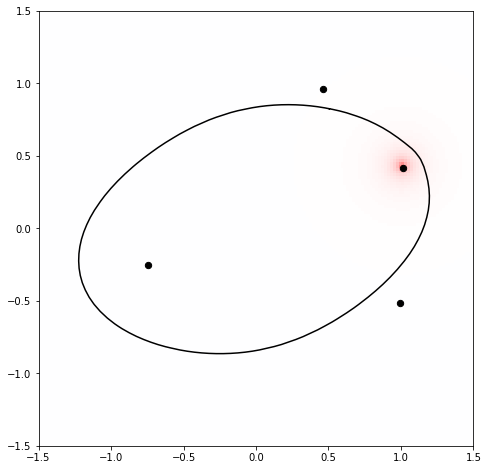

In [45]:
lens_system_smooth = lens_system.get_smooth_lens_system()
lensmodel_smooth, kwargs_smooth = lens_system_smooth.get_lensmodel()
print(kwargs[2])
print(halo_x, halo_y)
npix = 150
ran = 1.5
extension = LensModelExtensions(lensmodel)
ra_crit_list, dec_crit_list, ra_caustic_list, dec_caustic_list = extension.critical_curve_caustics(kwargs, 
                                                             compute_window=2*ran, grid_scale=0.05)


_x = np.linspace(-ran, ran, npix)
xx, yy = np.meshgrid(_x, _x)
shape0 = xx.shape
kappa_full = lensmodel.kappa(xx.ravel(), yy.ravel(), kwargs).reshape(shape0)
kappa_macro = lensmodel_smooth.kappa(xx.ravel(), yy.ravel(), kwargs_smooth).reshape(shape0)
substructure_convergence = kappa_full - kappa_macro

fig = plt.figure(1)
fig.set_size_inches(8, 8)
zero_point = np.mean(substructure_convergence)
plt.imshow(substructure_convergence - zero_point, vmin=-0.1, vmax=0.1, cmap='bwr', origin='lower',
          extent=[-ran, ran, -ran, ran])
plt.scatter(data.x, data.y, color='k', s=40)

plt.plot(ra_crit_list[0], dec_crit_list[0], color='k')